Ensemble learning : Combine the classifiers to form a meta-classifier which has better generalization performance than each of individual classifiers.  \
Most popular ensemble method : Majority voting principle - the class label which has been voted by majority of the classifiers is selected as the combined class label

if we have m classifiers - [c1, c2, c3, c4 ... cm] with each of its predictions being [p1,p2,p3 ... pm]. the final prediction is mode {p1,p2,p3 ... pm }. That is, the label with highest number of votes wins

Illustration :
individual classifier has an error rate of $\epsilon$, i.e probability of giving wrong label, and an ensemble of classifiers are used to give the prediction in the end. what will be the error rate of the combined classifier. we play around with different error rates and different number of classifier giving wrong or correct outputs


In [19]:
from scipy.special import comb # scipy.misc.comb is deprecated
import math
import numpy as np
def ensemble_error(n_classifier, error): # assume each of the classifiers has same error rate 'error'
    k_start = int(math.ceil(n_classifier/2.))
    probs = [comb(n_classifier,k)*(error**k)*((1-error)**(n_classifier-k)) for k in range(k_start,n_classifier+1)]
    return sum(probs)

In [7]:
probs = ensemble_error(11,0.25)
print(probs)

0.03432726860046387


In [21]:
#let us now change the error_rates and plot a graph 
errors = [ensemble_error(11, error) for error in np.arange(0,1.01,0.01)]

In [12]:
len(errors)


101

In [22]:
errors

[0.0,
 4.4254343383479994e-10,
 2.71207411810304e-08,
 2.957089768150355e-07,
 1.5898640480468992e-06,
 5.801345058593751e-06,
 1.656411575903354e-05,
 3.992476631525723e-05,
 8.500149873708894e-05,
 0.00016459292554947568,
 0.0002957060800000002,
 0.0004999803724290905,
 0.0008039907946370431,
 0.001239419514412758,
 0.0018430901570849726,
 0.0026568635802539054,
 0.0037273978509897755,
 0.0051057784699690125,
 0.0068470276914775734,
 0.009009504098156072,
 0.011654205440000008,
 0.014843989172661222,
 0.018642726163718218,
 0.023114403709482208,
 0.02832219435026633,
 0.03432750701904297,
 0.04118903683622163,
 0.0489618294000612,
 0.057696374745145676,
 0.06743774527655493,
 0.07822479095999996,
 0.09008940388240429,
 0.1030558630163423,
 0.11714026864751058,
 0.13235007447814498,
 0.1486837239211133,
 0.1661303955684304,
 0.18466986127225832,
 0.20427245873317543,
 0.22489917896571807,
 0.24650186752000006,
 0.26902353689468944,
 0.2923987861938412,
 0.3165543227701151,
 0.34140957

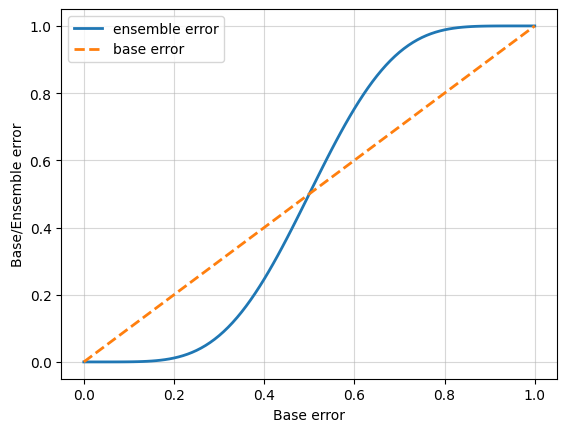

In [23]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,1.01,0.01),errors, label="ensemble error", linewidth=2)
plt.plot(np.arange(0,1.01,0.01), np.arange(0,1.01,0.01), linestyle='--', label="base error", linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

as long as the individual classifier error rate is lower than 0.5, ensemble classifier does a good job. But if it is greater than 0.5, we see an increase i ensemble error because good things keep adding up and bad things also get adding up in case of ensemble.

Combining classifier via a majority vote:
the objective is to build a stronger meta classifier that balances out the individual classifier's weaknesses. 
Weighted majority vote = $\hat{y} = argmax_i \sum_{j=1}^{m} w_j \chi _A$


In [24]:
# code to illustrate the importacne of weightage
np.argmax(np.bincount([0,0,1], weights=[0.2,0.2,0.6]))

1

two classifier say they predict 0 while one classifier says 1,so in equally weighted ensemble, it is hands down 0. but classifier 3 carries thrice the weightage of classifiers 1 and 2 and hence the ensemble says 1.

Some classifiers like svm, logistic regression return class probabilities as well -> predict_proba. 
Instead of labels 0 and 1, we can also use the class probability scores along with weights assigned to classifiers.
$\hat{y} = argmax(i) \sum _{j=1}^{m} w_jp_{ij}$


In [33]:
ex = np.array([[0.9,0.1],
              [0.8,0.2],
              [0.4,0.6]])
weights = np.array([0.2,0.2,0.6]).reshape(3,1)
ex_weights = weights.T @ ex
ex_weights

array([[0.58, 0.42]])

In [34]:
np.argmax(ex_weights)

0

In [37]:
#majority vote classifier class

from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import six
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators

class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, classifiers, vote='class_label', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key:value for key,value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self,X,y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            print(predictions.shape)
            maj_vote = np.apply_along_axis(lambda x : np.argmax(np.bincount(x,weights=self.weights)),axis=1,arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self,X):
        probas = np.asarray([clf.predict_proba(X)for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0,weights = self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name,key)] = value
            return out






Using the majority voting principle to make predictions

In [38]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
le.fit_transform(y)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, stratify=y, random_state=1)


In [40]:
X_train.shape, X_test.shape

((50, 2), (50, 2))

let us take three different classifiers : 
Decision tree classifeir, Logistic regression, K-nearest classifier

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


In [48]:
clf1 = LogisticRegression(penalty='l2',C=0.00001,random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc' ,StandardScaler()],['clf',clf3]])

clf_labels = ['Logistic Regression', 'DecisionTree Classifier', 'KNeighbor classifier']

for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC-AUC score is : {mean} +/- {std} [{label}]'.format(mean=scores.mean(),std=scores.std(),label=label))



ROC-AUC score is : 0.9166666666666666 +/- 0.1536590742882148 [Logistic Regression]
ROC-AUC score is : 0.8666666666666668 +/- 0.18333333333333332 [DecisionTree Classifier]
ROC-AUC score is : 0.85 +/- 0.13333333333333333 [KNeighbor classifier]


Since we have the individual classifier scores, we can now compile an ensemble of all these classifiers and get the majority score.

In [49]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority_vote']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    print("ROC-AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC-AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC-AUC: 0.87 (+/- 0.18) [DecisionTree Classifier]
ROC-AUC: 0.85 (+/- 0.13) [KNeighbor classifier]
ROC-AUC: 0.98 (+/- 0.05) [Majority_vote]


Majority vote does a very good job improving roc-auc score to 0.98 which is much better than each of the individual classifiers.

Evaluating and tuning the majority vote classifier

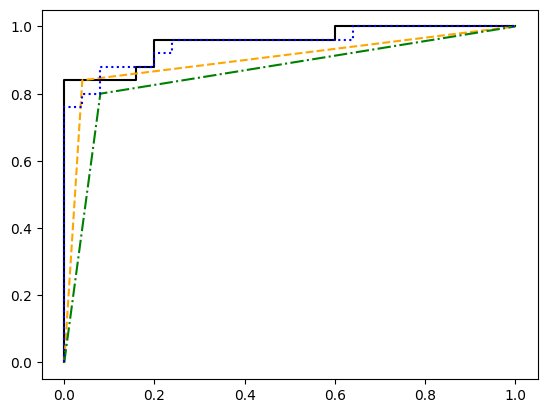

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'green', 'blue']
linespaces = ['-','--','-.',':']
for clf, label, color, ls in zip(all_clf, clf_labels,colors, linespaces):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1] # picking class 1 score [positive class]
    fpr, tpr , thresholds = roc_curve(y_true=le.fit_transform(y_test),y_score=y_pred)
    roc_auc=auc(x=fpr, y=tpr)
    plt.plot(fpr,tpr,color=color, linestyle=ls, label='{label} {auc}.2f'.format(label=label,auc=roc_auc))


In [52]:
#let us now get the parameters of the majority vote classifier
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=1e-05, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=1e-05, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=1e-05, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 1e-05,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [53]:
from sklearn.model_selection import GridSearchCV
params = {"decisiontreeclassifier__max_depth":[1,2],
          "pipeline-1__clf__C":[0.001,0.1,1.0,10.0,100.0]}
grid = GridSearchCV(mv_clf, param_grid=params, cv=10, scoring="roc_auc")
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=1e-05,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=1),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 1.0, 10.0, 100.0]},
             scoring='roc_auc')

In [64]:
results = grid.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_decisiontreeclassifier__max_depth', 'param_pipeline-1__clf__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [65]:
grid.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}

In [66]:
grid.best_score_

0.9833333333333334

Stacking is an algorithm where base classifier give out a prediction to level 2 algorithm. It is usually a simple algo like logistic regression. the base classifiers' predictions are used as dataset for this algorithm and it is expected to give actual prediction.

Bagging : another important ensemble learning method , also called bootstrap aggregating. the trainign set to each of the classifiers is not the same, the samples for a training set are drawn at random with replacement for a classifier. Random forest is a subset of bagging where the feature subsets are also taken.

In [67]:
# wine dataset with more features added.
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                         'machine-learning-databases/wine/wine.data',
                         header=None)

In [68]:
df_wine.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')

In [1]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                         'machine-learning-databases/wine/wine.data',
                         header=None)

In [2]:
df_wine.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')

In [3]:
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

In [4]:
df_wine['Class label'].unique()

array([1, 2, 3])

In [5]:
df_wine = df_wine[df_wine['Class label']!=1]

In [6]:
df_wine['Class label'].unique()

array([2, 3])

In [7]:
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values


In [9]:
X.shape,y.shape

((119, 2), (119,))

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [11]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, stratify=y)



In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


In [23]:
# accuracy of tree - base estimator
from sklearn.metrics import accuracy_score
tree = DecisionTreeClassifier(max_depth=7,random_state=1,criterion='entropy')
bag = BaggingClassifier(estimator=tree, n_estimators=500, max_samples=1.0,max_features=1.0 ,bootstrap=True, bootstrap_features=False,n_jobs=1,random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Decision tree accuracy : for train is {train_acc} and for test is {test_acc}".format(train_acc=train_accuracy,test_acc=test_accuracy))



Decision tree accuracy : for train is 0.9894736842105263 and for test is 0.9583333333333334


In [24]:
#accuracy of bagging classifier

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Bagging classifier accuracy : for train is {train_acc} and for test is {test_acc}".format(train_acc=train_accuracy,test_acc=test_accuracy))

Bagging classifier accuracy : for train is 1.0 and for test is 1.0


Adaptive boosting - leveraging weak learners via boosting :
Boosting consists of a ensemble of weak learners - classifier which are only slightly better than random guessing. Get hard samples which are hard to classify and let the weak learners have a shot at these and improve the ensemble through feedback which these weak learners receive.

Boosting:
1. Select samples d1 from training set without replacement and train a weak classifier c1 with it. 
2. Select samples d2 from training set without replacement and 50 percent of misclassifier samples from c1 and train c2 with this set of data.
3. Select samples d3 from training set + samples misclassified by both c1 and c2 into c3.
4. Combine majority vote classifiers c1,c2,c3 

In contrast to the original boosting procedure as described here, AdaBoost uses
the complete training set to train the weak learners where the training samples are reweighted in each iteration to build a strong classifier which learns from the mistakes of the previous weak learners in the ensemble

In [25]:
#applying adaboost in sklearn

from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1) # a very weak classifier
ada = AdaBoostClassifier(estimator=tree,n_estimators=500,learning_rate=0.1)
tree=tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Decision tree accuracy - train is {train_acc} and test is {test_acc}".format(train_acc=train_accuracy,test_acc=test_accuracy))


Decision tree accuracy - train is 0.8947368421052632 and test is 0.9583333333333334


In [26]:
ada=ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("adaboost accuracy - train is {train_acc} and test is {test_acc}".format(train_acc=train_accuracy,test_acc=test_accuracy))

adaboost accuracy - train is 1.0 and test is 1.0


There is clearly an improvement in adaboost accuracy which makes its classifiers learn from previous weak learners.

Decision region analysis:

In [30]:
import numpy as np
import matplotlib.pyplot as plt

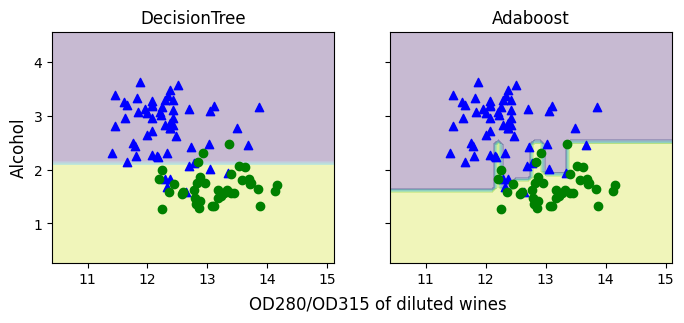

In [32]:
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1), np.arange(y_min, y_max,0.1))
f, axarr = plt.subplots(1,2,sharex='col',sharey='row', figsize=(8,3))

for idx , clf, tt in  zip([0,1], [tree,ada], ['DecisionTree','Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1],c='blue',marker='^')
    axarr[idx].scatter(X_train[y_train==1,0], X_train[y_train==1,1],c='green',marker='o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12)
plt.show()




Ensemble techniques often give us better metrics , but they also increase the computational complexity of the model. Compared to a simple classifier, an ensemble model is almost always computationally complex, the decision boundaries are often not interpretable and the engineering efforts required to do the same is high.

The netflix 1M dollar challenge was won by a team which used ensemble tree model , but it was never deployed by Netflix because of its sheer complexity and engineering efforts required to keep it running.